## Pipeline to Analyze MultiChannel System Recordings

- Recordings from Organoids treated with PTX -> see changes in network activity and compare between genotypes
- Pipeline:
    - file-by-file extract raw-traces, apply a bandfilter and calculate the RMS (root mean square error) for each trace individually
    - Set the threshold as a multiple of the RMS to detect spikes and calculate spike-dependent parameters
    - Calculate network-activity across all electrodes and generate raster plots -> burst activity and peak frequency calculations
- Run pipeline over all files and generate tables for statistical analysis to detect differences in genotypes to perturbations in network activity (PTX-treatment)



#### Import Libraries

Packages needed to run analysis

In [1]:
import spikeinterface.full as si
from spikeinterface.preprocessing import scale, common_reference
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from pathlib import Path
import os
import pandas as pd
from spikeinterface.extractors import read_mcsh5
import glob
import MCSTools
import openpyxl

#### Create a Loop to analyze all Files iteratively

Loop over all .h5 files in a folder and extract information

Difference to last version:
    - Save Excel Files per recording
    - Save the plots per recording

Analyzing .\canals\2023-11-20T09-55-24_E13_WT3_CTX_BASE.h5
Extracting Peaks, this might take a while...


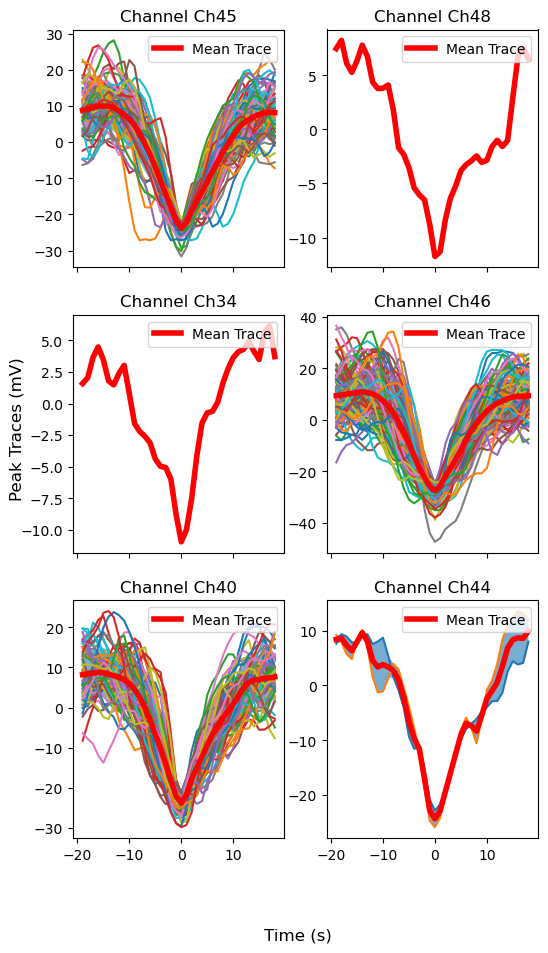

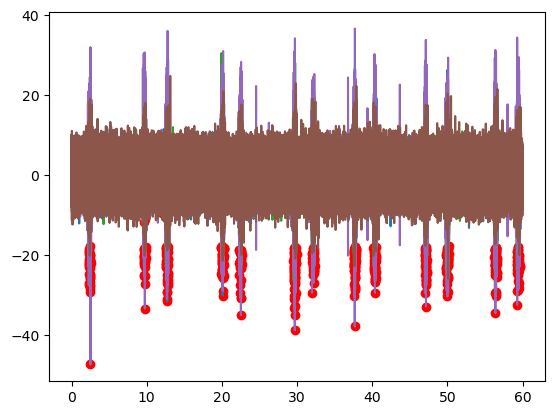

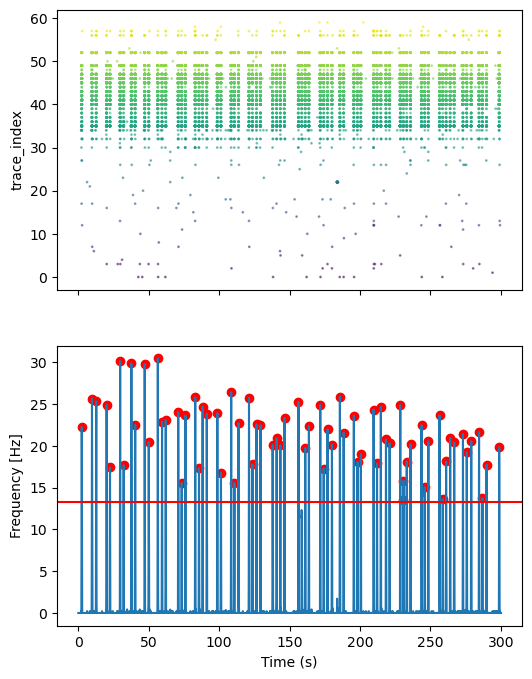

Analyzing .\canals\2023-11-20T10-07-46_E13_WT3_CTX_PTX.h5
Extracting Peaks, this might take a while...


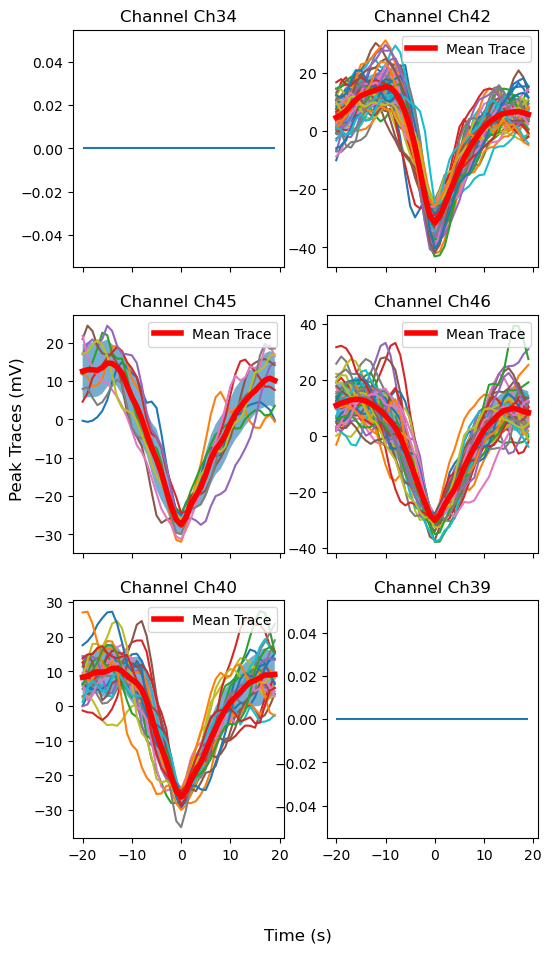

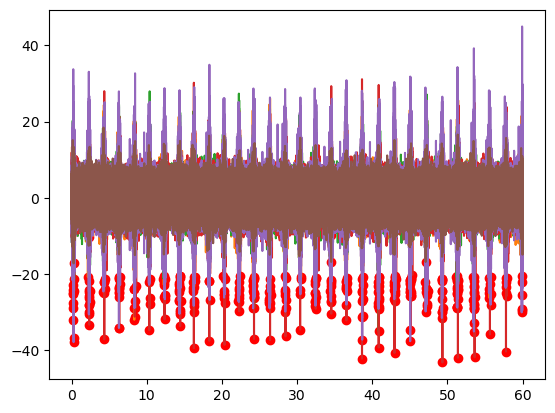

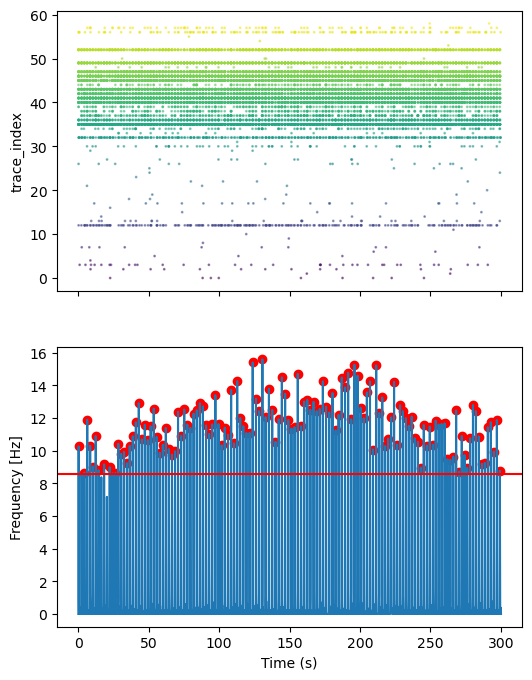

Analyzing .\canals\2023-11-20T10-20-50_E13_WT3_CTX_PTX_N+A.h5
Extracting Peaks, this might take a while...


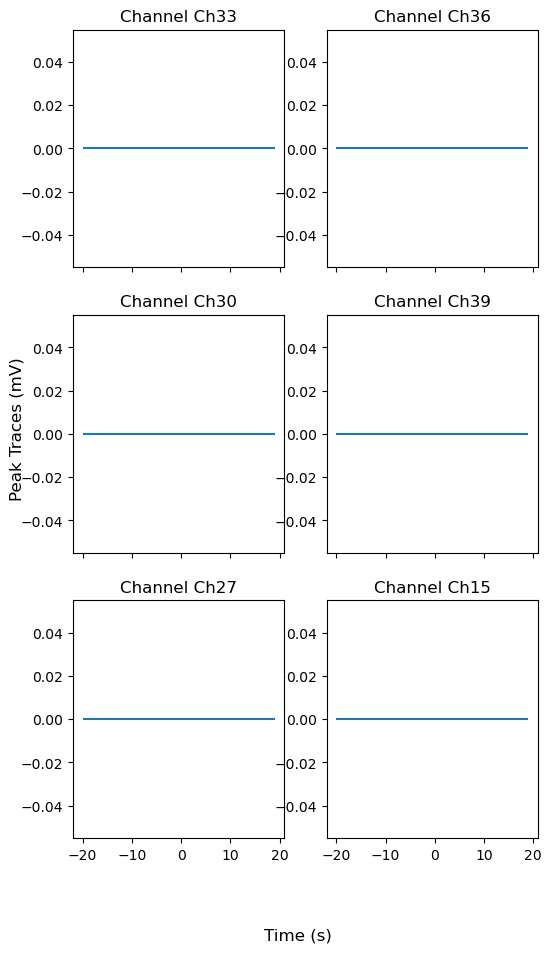

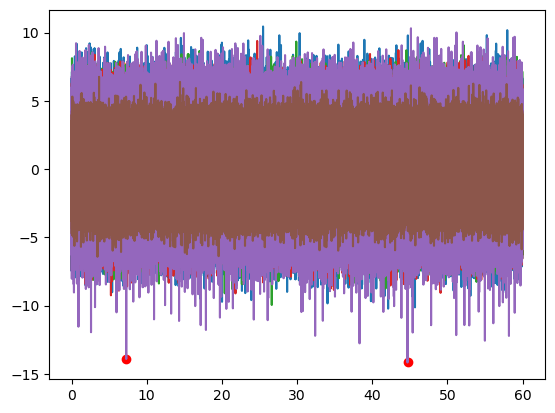

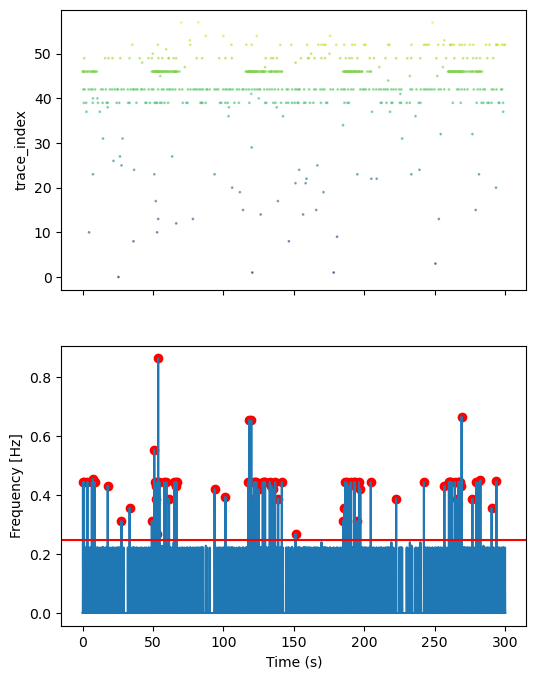

In [2]:
## Location of Raw files
files = glob.glob(".\\canals\\*.h5")
directory = ".\\Output"

if not os.path.exists(directory):
    os.makedirs(directory)

peak_table_list = []
burst_table_list = []

for file in files:
    print("Analyzing {}".format(file))
    
    filename = os.path.splitext(os.path.split(file)[1])[0]
    outpath = os.path.join(directory, filename)
    if not os.path.isdir(outpath):
        os.mkdir(outpath)

    mcs = read_mcsh5(file)
    fs = mcs.get_sampling_frequency()
    mcs_dict = mcs.to_dict()
    gain_to_uV = mcs_dict["properties"]['gain_to_uV'][0]
    mcs_scaled = scale(mcs, gain=gain_to_uV*10**6, offset=0.0, dtype='float32')
    
    filtered = si.bandpass_filter(mcs_scaled, freq_min=300, freq_max=9000)
    channels = filtered.channel_ids
    
    
    print("Extracting Peaks, this might take a while...")
    
    peak_table = MCSTools.compute_peaks(filtered)
    peak_table.File = file
    burst_table = MCSTools.compute_burst_activity(peak_table, filtered, plotRaster=False)
    burst_table.File = file
    
    indeces = MCSTools.get_most_active_channels(peak_table[peak_table["File"] == file])
    #print(indeces)
    MCSTools.plot_spikes(filtered, channels[indeces.index], startTime=0, endTime=60)
    #plt.show()
    plt.savefig(os.path.join(outpath, filename + "_peaks.png"))
    plt.show()
    
    MCSTools.plot_traces(filtered, channels[indeces.index], startTime=0, endTime=60)
    #plt.show()
    plt.savefig(os.path.join(outpath, filename + "_traces.png"))
    plt.show()
    #MCSTools.plot_traces(filtered, channels[40:45], startTime=0, endTime=10)
    #MCSTools.plot_spikes(filtered, channels[40:45], startTime=0, endTime=60)
    MCSTools.compute_burst_activity(peak_table,filtered, plotRaster=True, startTime=0, endTime=60)
    #plt.show()
    plt.savefig(os.path.join(outpath, filename + "_burst.png"))
    plt.show()
    #peak_table_list.append(peak_table)
    #burst_table_list.append(burst_table)
    
        
    with pd.ExcelWriter(os.path.join(outpath, filename + ".xlsx" )) as writer:
        peak_table.to_excel(writer, sheet_name='Peak Level Analysis')
        burst_table.to_excel(writer, sheet_name='Burst Level Analysis')
    
    
    
#peak_table = pd.concat(peak_table_list, ignore_index=True)
#burst_table = pd.concat(burst_table_list, ignore_index=True)

## Table of Peak Parameters

This table can be also aggregated per channel or per recording/condition

In [20]:
peak_table

,File,trace_index,channel,event,peak_index,peak_time_s,event_window_start,event_window_end,Amplitude_mV,width_ms,inst_freq,isi_s,area
0,.\canals\2023-11-20T09-55-24_E13_WT3_CTX_BASE.h5,0,Ch0,1,852021,42.60105,8.095141e+05,8.715780e+05,-8.764248,3096.196322,NaN,0.00000,0.21
1,.\canals\2023-11-20T09-55-24_E13_WT3_CTX_BASE.h5,0,Ch0,2,908095,45.40475,6.850436e+05,1.017634e+06,-8.787904,16622.522402,0.202961,2.80370,1.085
2,.\canals\2023-11-20T09-55-24_E13_WT3_CTX_BASE.h5,0,Ch0,3,1133691,56.68455,6.850435e+05,1.161735e+06,-8.930639,23827.574650,0.044582,11.27980,0.01
3,.\canals\2023-11-20T09-55-24_E13_WT3_CTX_BASE.h5,0,Ch0,4,1236468,61.82340,6.850433e+05,4.422567e+06,-9.504307,186869.186046,0.036272,5.13885,0.895
4,.\canals\2023-11-20T09-55-24_E13_WT3_CTX_BASE.h5,0,Ch0,5,2765401,138.27005,2.260168e+06,3.141787e+06,-9.172585,44073.944870,0.009614,76.44665,0.345
...,...,...,...,...,...,...,...,...,...,...,...,...,...
41907,.\canals\2023-11-20T10-20-50_E13_WT3_CTX_PTX_N...,54,Ch54,3,2475584,123.77920,1.477857e+06,2.506631e+06,-7.451575,51431.699656,0.040993,23.76930,0.2
41908,.\canals\2023-11-20T10-20-50_E13_WT3_CTX_PTX_N...,54,Ch54,4,3516089,175.80445,2.761605e+06,5.547712e+06,-7.083327,139298.349849,0.009813,52.02525,0.215
41909,.\canals\2023-11-20T10-20-50_E13_WT3_CTX_PTX_N...,57,Ch57,1,1403009,70.15045,1.296004e+06,1.543705e+06,-10.690085,12378.046055,NaN,0.00000,0.265
41910,.\canals\2023-11-20T10-20-50_E13_WT3_CTX_PTX_N...,57,Ch57,2,1645695,82.28475,4.137770e+05,1.959392e+06,-10.893263,77273.766466,0.057200,12.13430,0.82


In [17]:
MCSTools.get_most_active_channels(peak_table, n_channels=30)

45    2688
34    2196
40    2180
48    2147
46    2029
44    1991
42    1986
39    1851
51    1448
41    1285
35     603
36     491
37     354
38     312
43     266
31     180
33     144
47     110
54     103
55      57
29      52
22      21
26      18
27      13
0       12
3       12
32      12
12      10
17      10
13       6
Name: (peak_index, count), dtype: int64

In [7]:
for channel in peak_table["channel"].unique():
    #print(channel)
    if max(peak_table.loc[peak_table["channel"] == channel, "event"]) < 10:
        peak_table[peak_table["channel"] == channel].drop()
        
peak_table

TypeError: '<' not supported between instances of 'str' and 'int'

## Table of Burst Statistics

This table can be also aggregated per recording/condition

Saved as a new sheet in an excel

In [21]:
burst_table

,File,burst_index,burst_frame,burst_time_s,event_window_start,event_window_end,Burst_Peak_frequency,width_ms,inst_freq,isi_s,area
0,.\canals\2023-11-20T09-55-24_E13_WT3_CTX_BASE.h5,1,243,0.01215,31.605548,453.787821,22.239117,1.109114,NaN,0.00000,27.835
1,.\canals\2023-11-20T09-55-24_E13_WT3_CTX_BASE.h5,2,971,0.04855,758.695222,1185.553022,25.604554,1.342890,27.049162,0.03640,32.735
2,.\canals\2023-11-20T09-55-24_E13_WT3_CTX_BASE.h5,3,1275,0.06375,1060.459380,1483.691115,25.318599,1.161587,63.230155,0.01520,30.325
3,.\canals\2023-11-20T09-55-24_E13_WT3_CTX_BASE.h5,4,2009,0.10045,1796.397401,2220.769315,24.886818,1.218596,26.718657,0.03670,30.745
4,.\canals\2023-11-20T09-55-24_E13_WT3_CTX_BASE.h5,5,2251,0.11255,2036.408771,2462.825452,17.398936,1.320834,78.553794,0.01210,21.61
...,...,...,...,...,...,...,...,...,...,...,...
282,.\canals\2023-11-20T10-20-50_E13_WT3_CTX_PTX_N...,75,27946,1.39730,27742.454859,28149.545141,0.443269,0.354514,75.308742,0.01305,0.995
283,.\canals\2023-11-20T10-20-50_E13_WT3_CTX_PTX_N...,76,28110,1.40550,27906.454859,28313.545141,0.443269,0.354514,119.370814,0.00820,1.245
284,.\canals\2023-11-20T10-20-50_E13_WT3_CTX_PTX_N...,77,28253,1.41265,28044.518308,28456.508597,0.449600,0.599514,136.476718,0.00715,0.91
285,.\canals\2023-11-20T10-20-50_E13_WT3_CTX_PTX_N...,78,29048,1.45240,28843.487004,29252.512996,0.354942,0.451300,24.891669,0.03975,0.43


In [22]:
with pd.ExcelWriter('./Results_I_Canals.xlsx') as writer:
    peak_table.to_excel(writer, sheet_name='Peak Level Analysis')
    burst_table.to_excel(writer, sheet_name='Burst Level Analysis')